In [65]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

# Chicago Car Crash Analysis

## Overview 
For this project we were given two dataframes from the [Chicago Data Portal](https://data.cityofchicago.org/), ([Traffic Crashes-People](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data) and [Traffic Crashes-Vehicles](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3/about_data)). We decided to use a third dataframe, [Traffic Crashes-Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data), to help with merging the other two dataframes together. These dataframes were filled with accidents that happened in the city of Chicago. After merge, we took a 350,000 sample and filtered for drivers who were aged 15 to 22 (young drivers) and were residents of Illinois. We then created three different models to track serious injuries (incapacitated ones and fatalities) and find the coefficients that caused them with their values.

## Business Problem

We an advertisement company hired by the City of Chicago to create a series of safe driving Public Safety Anncouncements for young adults. 

These ads will run on social media as well as being posted near high schools and college campuses. 

In order to figure out what ads will be the most effective, we are examining the causes of fatal accidents for the age range: 15-22 year olds. Once we determine the most common causes of accidents, we will be able to tailor our ads for the city, and hopefully reduce fatalities for young drivers.

## Data Source 

Car crash and vehicle accident data was sourced from the [Chicago Data Portal](https://data.cityofchicago.org/). It originates from the [City of Chicago](http://www.chicago.gov/).

Data collection began in 2015, but was only adopted by all Chicago district police departments in 2017. The most recent data entry was from September 26, 2024. 

## Results

# FILL IN

# Data Import and Cleaning 

In [66]:
#df_vehicles = pd.read_csv("data/Traffic_Crashes_Vehicles.csv")
#df_people = pd.read_csv("data/Traffic_Crashes_People.csv")
#df_crashes = pd.read_csv("data/Traffic_Crashes_Crashes.csv")

## Merge Dataframes

First we sample 300,000 crash reports, then we merge the vehicle and people involved. 

In [67]:
#Random sample of vehicles 
#df_accidents = df_vehicles.sample(n=350000, random_state=42)

In [68]:
#Then we can add the crash report data 
#df_accidents = df_accidents.merge(df_crashes, how="inner", on=["CRASH_RECORD_ID", "CRASH_DATE"])

In [69]:
#every person and vehicle should have a match for the record ID, vehicle ID, and crash date
#This makes the dataframe larger as multiple people are involved in each accident 
#df_accidents = df_accidents.merge(df_people, how="inner", on=["CRASH_RECORD_ID", "VEHICLE_ID", "CRASH_DATE"])

The dataframe gets larger when merging in the people, as there are sometimes more than one person involved in an accident.  

## Export Final

In [70]:
#df_accidents.to_csv('data/Final_Data.csv')

## Read Final

In [71]:
#reads in the sample that we took above. For ease we have attached a zip file that needs to be extracted into the data folder
df_accidents = pd.read_csv("data/Final_Data.csv")

C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,55,58,59,61,71,102,123,143) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Formatting and Filtering

In [72]:
#Sets all column names to lowercase
df_accidents.columns = [column.lower() for column in df_accidents.columns]
#have the crash date as a datetime object. 
df_accidents['crash_date'] = pd.to_datetime(df_accidents['crash_date'], format="%m/%d/%Y %I:%M:%S %p")
#filters for ages 15-22 who are the driver of the vehicle and have an Illinois license
df_accidents = df_accidents.loc[(df_accidents['age'] > 14) & (df_accidents['age'] < 23) & 
                                (df_accidents['person_type'] == 'DRIVER') & (df_accidents['state'] == 'IL')]
df_accidents
#drops rows that dont have a vehicle year
df_accidents = df_accidents.loc[df_accidents['vehicle_year'].notna()]

## Drop Unnecessary Columns

In [73]:
#remove columns with less than 50% of data present 
df_accidents.dropna(axis=1, thresh = int(0.5*df_accidents.shape[0]), inplace=True)

#list of columns to drop
cols_to_drop = [
#remove unnecessary id columns now the data is joined 
'vehicle_id', 'crash_record_id', 'crash_unit_id',
#drops columns that are associated with location as we already have the location column
'latitude', 'longitude', 'street_no', 'street_direction', 'street_name', 'travel_direction',
#police specific 
'beat_of_occurrence', 
#not needed when we have the state of the person involved with the crash
'city', 'zipcode', 
#covered by most_severe_injury
'injury_classification',
#many NAN
'injuries_unknown'
]
df_accidents.drop(columns=cols_to_drop, inplace=True)

## Convert categorical columns to numeric columns

In [74]:
#map the weather to a number 
def weather_code(weather):
    """
    0 - Unknown, Clear, Clouds
    1 - Rain, Snow, Freezing Rain/Drizzle, Sleet/Hail, Blowing Snow, Fog/Smoke/Haze, Blowing Sand/Soil/Dirt
    """
    #unserious weather condition
    if weather in ['CLEAR', 'CLOUDY/OVERCAST']:
        return 0
    #serious weather condition
    elif weather in ['RAIN', 'SNOW', 'FREEZING RAIN/DRIZZLE', 'SLEET/HAIL', 'BLOWING SNOW', 'FOG/SMOKE/HAZE', 
                     'BLOWING SAND/SOIL/DIRT']:
        return 1
    #unknown weather condition
    return 0
    
df_accidents['weather_condition'] = df_accidents['weather_condition'].map(weather_code)

In [75]:
#map the lighting conditions
def lighting(lighting_condition):
    """
    0 - Unknown, Daylight
    1 - Darkness, Dusk, Dawn, Darkness (Lighted Road)
    """
    #night lighting conditions
    if lighting_condition in ['DARKNESS', 'DUSK', 'DAWN', 'DARKNESS (LIGHTED ROAD)']:
        return 1
    #daytime/unknown lighting conditions
    return 0
df_accidents['lighting_condition'] = df_accidents['lighting_condition'].map(lighting)
df_accidents['lighting_condition'].value_counts()

0    17089
1     1677
Name: lighting_condition, dtype: int64

In [76]:
#map the injuries to a number 
def injury_severity(severity):
    """
    Injuries are categorized on a scale of 0 to 1
    0 - No Indication of Injury 
    0 - REPORTED, NOT EVIDENT 
    0 - Nonincapacitating Injury 
    1 - incapacitating Injury 
    1 - Fatal Injury 
    """
    #Serious Injury
    if severity in ['INCAPACITATING INJURY', 'FATAL']:
        return 1
    #No Injury or Minor Injury
    else:
        return 0
    

df_accidents['serious_injury'] = df_accidents['most_severe_injury'].map(injury_severity)

In [77]:
#drop the columns 
in_cols_to_drop = [
#remove counts of each injury 
'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating',
'injuries_reported_not_evident', 'injuries_no_indication'
]

df_accidents.drop(columns=in_cols_to_drop, inplace=True)

In [78]:
#map primary and secondary contributory cause into different categories
def bin_cause(cause):
    #Fault of the driver
    if cause in ['DISREGARDING TRAFFIC SIGNALS', 'IMPROPER LANE USAGE', 'FOLLOWING TOO CLOSELY', 
                   'IMPROPER TURNING/NO SIGNAL', 'IMPROPER OVERTAKING/PASSING', 'FAILING TO YIELD RIGHT-OF-WAY',
                   'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING STOP SIGN',
                   'FAILING TO REDUCE SPEED TO AVOID CRASH', 
                   'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
                   'IMPROPER BACKING', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
                   'EXCEEDING AUTHORIZED SPEED LIMIT', 'DRIVING ON WRONG SIDE/WRONG WAY',
                   'DISREGARDING ROAD MARKINGS', 'EXCEEDING SAFE SPEED FOR CONDITIONS', 'DISREGARDING YIELD SIGN',
                   'TURNING RIGHT ON RED', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 'PASSING STOPPED SCHOOL BUS',
                   'RELATED TO BUS STOP', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT']:
        return 1
    #driver is inebriated or shouldnt be driving due to their physicality     
    elif cause in ['UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)', 
                   'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)', 'PHYSICAL CONDITION OF DRIVER']:
        return 2
    #distracted driver
    elif cause in ['DISTRACTION - FROM INSIDE VEHICLE', 'DISTRACTION - FROM OUTSIDE VEHICLE', 
                   'CELL PHONE USE OTHER THAN TEXTING', 
                   'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)', 
                   'TEXTING']:
        return 3     
    #fault of vehicle, road, or nature
    elif cause in ['EQUIPMENT - VEHICLE CONDITION', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'
                 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
                 'OBSTRUCTED CROSSWALKS', 'ROAD CONSTRUCTION/MAINTENANCE', 'WEATHER', 'ANIMAL', 'NOT APPLICABLE']:
        return 4
    #unknown
    return 0
#main cause    
df_accidents['prim_contributory_cause'] = df_accidents['prim_contributory_cause'].map(bin_cause)
#secondary cause
df_accidents['sec_contributory_cause'] = df_accidents['sec_contributory_cause'].map(bin_cause)  

In [79]:
#mapping vehicle defects
def vehicle_defect_clf(defect):
    ''' 
    0 = No / Unknown defect

    1 = Has a defect 
    '''
    #no defects
    if defect in ['NONE', 'UNKNOWN']:
        return 0
    #has defect
    return 1
df_accidents['vehicle_defect'] = df_accidents['vehicle_defect'].map(vehicle_defect_clf)

## Examine Correlations

In [80]:
df_matrix = df_accidents.select_dtypes(exclude=['object'])

matrix = df_matrix.corr()
print(matrix)

                         unnamed: 0   unit_no  vehicle_year  vehicle_defect  \
unnamed: 0                 1.000000 -0.030351      0.000073        0.006591   
unit_no                   -0.030351  1.000000      0.026196       -0.068996   
vehicle_year               0.000073  0.026196      1.000000        0.001085   
vehicle_defect             0.006591 -0.068996      0.001085        1.000000   
occupant_cnt              -0.014501  0.049222      0.001302       -0.007074   
posted_speed_limit        -0.015691  0.047335      0.003955        0.006839   
weather_condition         -0.008608 -0.020038     -0.012835        0.004826   
lighting_condition         0.002715  0.014262     -0.006905       -0.004310   
prim_contributory_cause   -0.010192 -0.052266     -0.008569        0.141883   
sec_contributory_cause    -0.008573 -0.017701      0.005074        0.020249   
num_units                 -0.048291  0.187261      0.002157       -0.020337   
injuries_total            -0.016062  0.011026      0

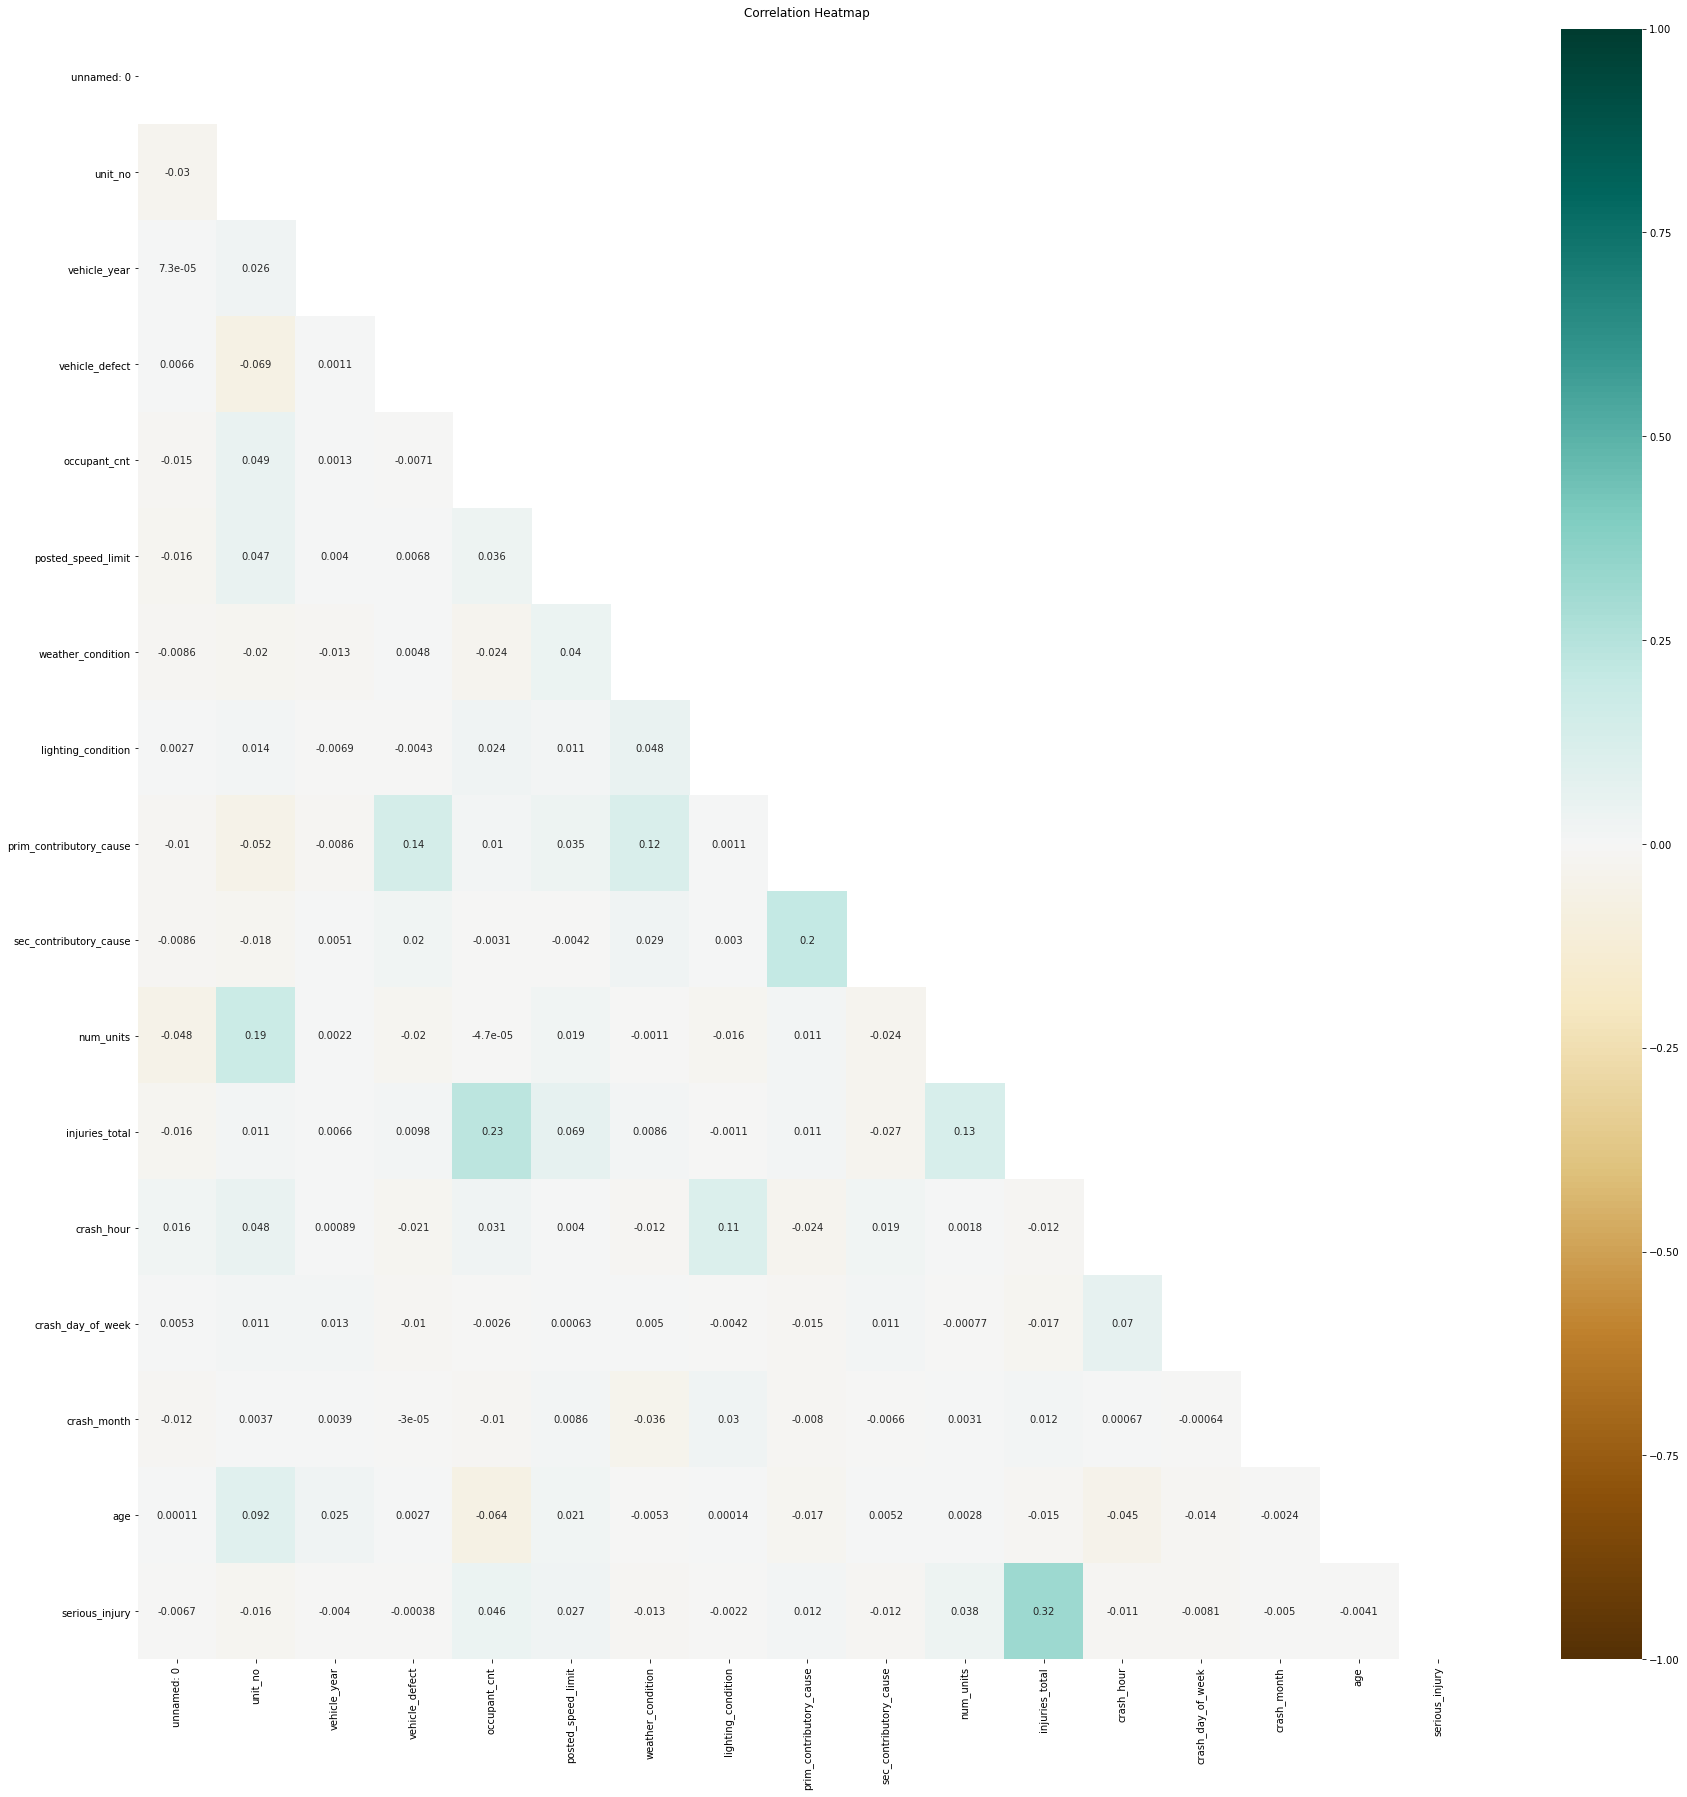

In [81]:
plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

heatmap = sns.heatmap(matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Model 1: Decision Tree

Create a decision tree to evaluate which variables make crashes more likely to cause fatal injury.

In [83]:
#Train-Test Split
X = df_accidents.select_dtypes(exclude=['object'])
X = X.drop(columns='serious_injury')
#columns dropped either for no relation to our target, not able to advice in changing like vehicle year,
#or track the same variables as our target
X = X.drop(columns=['unnamed: 0', 'crash_date', 'unit_no', 'num_units', 'injuries_total', 'vehicle_year'])
y = df_accidents['serious_injury']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2)

In [84]:
#examine data balance (imbalanced)
y.value_counts()

0    18321
1      445
Name: serious_injury, dtype: int64

In [86]:
tree_clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=100)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=100, random_state=42)

In [87]:
print('Training:', tree_clf.score(X_train, y_train))
print('Testing:', tree_clf.score(X_test, y_test))

Training: 0.9762682961489271
Testing: 0.9763427109974424


In [88]:
print(classification_report(y_test, tree_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4581
           1       0.00      0.00      0.00       111

    accuracy                           0.98      4692
   macro avg       0.49      0.50      0.49      4692
weighted avg       0.95      0.98      0.96      4692



C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
feature_used = X.columns

for fi, feature in zip(tree_clf.feature_importances_, feature_used):
    print(fi, feature)


0.0 vehicle_defect
0.11926541016538851 occupant_cnt
0.040461663146835865 posted_speed_limit
0.03179449635367091 weather_condition
0.01951283452968308 lighting_condition
0.022280532714151084 prim_contributory_cause
0.11400861025832724 sec_contributory_cause
0.2853411892871748 crash_hour
0.11621250349742987 crash_day_of_week
0.11525495291451944 crash_month
0.13586780713281915 age


Through our decision tree, we can see that the most significant factors in determining if a crash will be fatal include: 
- Occupant Count
- Secondary Contributory Cause
- Crash Hour
- Crash Month
- Age

# Model 2: Baseline

In order to evaluate how well we can predict, and hopefully prevent, crashes, we used the most significant variable, Crash Hour, to establish a baseline logistic regression model.

In [102]:
X_train_baseline = X_train[['crash_hour']]
X_test_baseline = X_test[['crash_hour']]

In [103]:
smote = SMOTE(random_state=2)
X_train_res, y_train_res = smote.fit_resample(X_train_baseline, y_train)

In [104]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_res, y_train_res)
baseline_model.score(X_train_res, y_train_res)

0.5075691411935953

In [107]:
y_pred = baseline_model.predict(X_test_baseline)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.60      0.75      4581
           1       0.02      0.41      0.05       111

    accuracy                           0.60      4692
   macro avg       0.50      0.50      0.40      4692
weighted avg       0.95      0.60      0.73      4692



0.40540540540540543

Our baseline is able to predict fatal crashes around 50% of the time

# Model 3: Logistic Regression

To improve our baseline, we examined more factors in a multiple linear regression. 

In [111]:
#scale values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)

#make train sample more balanced
sm = SMOTE(random_state=99, sampling_strategy=0.9)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train_scaled, y_train)

#logistic model with more features
log = LogisticRegression(random_state=101)
log.fit(X_train_oversampled, y_train_oversampled)

LogisticRegression(random_state=101)

In [112]:
#coefficients
np.exp(log.coef_)

array([[1.00876907, 1.17285683, 1.30719194, 0.87909238, 1.00035595,
        1.13667017, 0.83296631, 0.98452614, 0.96776609, 0.99281148,
        0.99023659]])

In [113]:
print('Training:', log.score(X_train_oversampled, y_train_oversampled))
print('Testing:', log.score(X_test_scaled, y_test))

Training: 0.5768405730483414
Testing: 0.6928815004262575


In [114]:
print(classification_report(y_test, log.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      4581
           1       0.03      0.38      0.06       111

    accuracy                           0.69      4692
   macro avg       0.50      0.54      0.44      4692
weighted avg       0.96      0.69      0.80      4692



Conclusions from model 2.
# FILL IN

# Conclusions 

## Education Campaign Focus Topics

Promote safer driving in young adults by: 

- Focusing our educational campaign on late night driving skills

- Educate young adults on the extra risk of driving on weekends and risk of carpooling

- Encourage young adults to obey Chicago speed limits

- Promote Vision 0 initiatives in schools. 


# Next Steps

## Expand on Crash Location and Demographics

Examine the data in conjunction with Economic Hardship Data and Census information.

Vision 0 has already found correlation between accidents and historically poor areas: how can we improve driver education for these areas? 

Can we connect with the community to drive change?

## Expand our analysis to focus on Dangerous Roads and Speed Corridors

Teach young adults about what roads are the most dangerous and how to best navigate them. 


# Appendix

In [87]:
count = 0
for column in df_accidents.iloc[0]:
    print(df_accidents.columns[count], ":", column, ",", df_accidents.iloc[1].iloc[count])
    count += 1

unnamed: 0 : 44 , 51
crash_date : 2020-08-15 21:00:00 , 2017-11-14 14:30:00
unit_no : 2 , 1
unit_type : DRIVER , DRIVER
make : VOLKSWAGEN , TOYOTA MOTOR COMPANY, LTD.
model : JETTA , TOYOTA
lic_plate_state : IL , IL
vehicle_year : 2014.0 , 2006.0
vehicle_defect : 0 , 0
vehicle_type : PASSENGER , PASSENGER
vehicle_use : PERSONAL , PERSONAL
maneuver : STRAIGHT AHEAD , STRAIGHT AHEAD
occupant_cnt : 2.0 , 1.0
first_contact_point : SIDE-LEFT , FRONT
posted_speed_limit : 30 , 35
traffic_control_device : NO CONTROLS , STOP SIGN/FLASHER
device_condition : NO CONTROLS , FUNCTIONING PROPERLY
weather_condition : 0 , 0
lighting_condition : 0 , 0
first_crash_type : SIDESWIPE SAME DIRECTION , ANGLE
trafficway_type : NOT DIVIDED , ONE-WAY
alignment : STRAIGHT AND LEVEL , STRAIGHT AND LEVEL
roadway_surface_cond : DRY , DRY
road_defect : NO DEFECTS , UNKNOWN
report_type : NOT ON SCENE (DESK REPORT) , NOT ON SCENE (DESK REPORT)
crash_type : 0 , 1
damage : OVER $1,500 , OVER $1,500
date_police_notified :

In [ ]:
#map the crash severity to a number 
def crash_severity(severity):
    """
    Injuries are categorized on a scale of 0 to X
    0 - No Injury / Drive Away 
    1 - Injury and / or tow  
    """
    if severity == 'NO INJURY / DRIVE AWAY':
        return 0
    else:
        return 1
    

df_accidents['crash_type'] = df_accidents['crash_type'].map(crash_severity)